#### 유방암 데이터
- 유방암 환자(M)
- 정상인(B)
- 2개의 클래스와 30개의 특성변수로 구성된 자료 (특성변수=세포핵의 디지털 이미지 자료)

In [1]:
# Load breast cancer data
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
df.shape

(569, 32)

In [2]:
# X, y 변수 스케일링
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values  # 30개의 feature를 할당
y = df.loc[:, 1].values   # 텍스트 데이터(B, M class)

le = LabelEncoder()
y = le.fit_transform(y)   # class [B, M]을 class [0, 1]로 전환
le.classes_
le.transform(['M', 'B'])  # 확인

array([1, 0])

In [3]:
print(1-y.mean())
# 학습데이터와 시험데이터에서의 모형의 성능이 최소한 0.63 이상이 되어야 모형의 기능을 할 수 있다.
# 63%는 특성변수를 전혀 사용하지 않고 어떤 자료든 관계없이 y를 0으로 무조건 분류하면 63%의 정밀도를 보이기 때문

0.6274165202108963


In [4]:
# 전체 data를 training data와 test data로 split (8:2)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    stratify=y, random_state=1)

특성변수가 지나치게 큰 경우에는 PCA/LDA와 같은 차원축소 과정을 거친 후에 분류나 회귀 모형을 거치게 된다.<br>
이를 일일이 결과로 받아 적용하는 것은 힘드므로 pipeline을 이용할 수 있다.
- PCA 사용시 자료의 측도에 따른 왜곡을 피하기 위해 자료의 표준화가 필요함

In [6]:
# Pipeline Streaming: 표준화 → PCA → Logistic Regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),  # 표준화
                        PCA(n_components=4),  # PCA로 차원축소
                        LogisticRegression(random_state=1, solver='lbfgs'))  # 적용 순서대로 나열

pipe_lr.fit(X_train, y_train)            # 표준화(fit → transform) → PCA(fit → transform) → Logistic Reg fit의 순서로 처리
y_train_pred = pipe_lr.predict(X_train)  # 표준화 transform → PCA transform → Logistic Reg prediction 순서로 처리
y_test_pred = pipe_lr.predict(X_test)

1. pipe_lr.fit(x_train, y_train): <br>
표준화 fit -> 표준화 transformation -> PCA fit -> PCA transformation -> Logistic regression fit
2. pipe_lr.predict(x_train)/pipe_lr.predict(x_test): <br>
표준화 transformation -> PCA transformation -> Logistic regression fit

In [7]:
# Accuracy score
print(pipe_lr.score(X_train, y_train))  # Training accuracy
print(pipe_lr.score(X_test, y_test))    # Test accuracy

0.967032967032967
0.956140350877193


### K-fold CV

In [8]:
# K-fold cross-validation using pipeline
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, 
                         X=X_train, 
                         y=y_train, 
                         cv=10)  # Accuracy scores
print('CV accuracy scores: %s' % scores)

# mean, sd of scores
import numpy as np
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.97826087 0.95652174 0.95652174 0.95652174 0.91304348 0.95555556
 0.97777778 0.97777778 1.         0.97777778]
CV accuracy: 0.965 +/- 0.022


### Bias-Variance trade-off

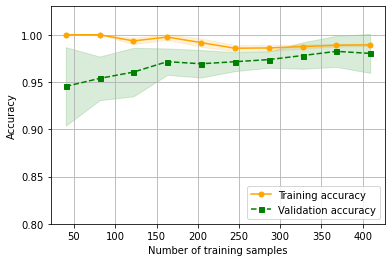

In [15]:
# Bias-variance trade-off 그래프로 확인
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1, solver='lbfgs'))
train_sizes, train_scores, test_scores =\
             learning_curve(estimator=pipe_lr, 
                            X=X_train, 
                            y=y_train,
                            train_sizes=np.linspace(0.1, 1.0, 10),  # 균등하게 10등분으로 분할
                            cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean, color='orange', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='orange')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

# 과대/과소적합이 발생하고 있지 않음.

### GridSearch
CV의 목적은 초모수의 결정에 있으므로 GridSearch를 이용해서 최적의 초모수를 찾아볼 수 있다.

In [11]:
# Grid search에 의한 초모수 결정 (SVM)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# SVC의 종류와 파라미터 중 가장 높은 값을 Grid Search로 찾기
pipe_svc = make_pipeline(StandardScaler(), 
                         SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range,  # gamma: variance의 역수, rbf에 필요한 파라미터
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

# Grid search를 통해 찾은 가장 높은 성능의 estimator 출력
clf = gs.best_estimator_  # 최적의 모형을 검증데이터를 포함한 전체 학습데이터에 적합해서 모수 재추정
clf.fit(X_train, y_train)
print("Best estimator Accuracy:", clf.score(X_train,y_train))  # 최종 정밀도=0.974
clf.score(X_test, y_test)

# 최종적으로 C=100, 커널은 방사형기저함수, 함수 내에서 0.001을 가진 비선형 커널 SVM이 가장 높은 검증 정밀도를 가짐

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best estimator Accuracy: 0.989010989010989


0.9736842105263158

### Nested CV
: 5-3 중첩 교차검증 이용
- 5-분할 CV=외곽루프 (전체 자료를 5개 분할로 학습데이터+시험데이터 분할)
- 3-분할 CV=내부루프 (학습데이터를 3개 분할로 학습데이터+검증데이터 분할)

- 내부루프의 목적: 초모수의 결정이므로 GridSearchCV() 사용
- 외부루프의 목적: 시험데이터의 성능을 점검하므로 cross_val_score() 사용

In [12]:
# Nested cross-validation을 이용한 초모수 결정
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid,
                  scoring='accuracy', 
                  cv=3)
# cross_val_score(): 시험데이터의 loss의 불편추정치 계산
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)

print('CV accuracy: %.8f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.97893184 +/- 0.007


그 결과, SVM 모형이 분류나무모형보다 더 높은 정밀도를 보이므로 더 우수한 분류모형이라고 할 수 있다. (0.976>0.936)

### Decision Tree (K-fold CV)
: Decision tree classifier을 이용해서 구하는 CV에서 가장 좋은 초모수 GridSearch로 찾기
- KFold의 장점 = shuffle=True를 부여해 교차검증을 위한 분할 이전에 자료를 잘 뒤섞을 수 있다.

In [13]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy', cv=inner_cv)

scores = cross_val_score(gs, X, y, scoring='accuracy', cv=outer_cv)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.944 +/- 0.012


### Decision Tree (Stratified CV)
- Stratified CV: 각 분할의 클래스 비율이 전체 클래스 비율과 동일하도록 하는 층화 k-분할 교차검증 방법

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

inner_cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy', cv=inner_cv)

scores = cross_val_score(gs, X, y, scoring='accuracy', cv=outer_cv)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.912 +/- 0.021


통계적으로 shuffle한 것이 옳고, 목적변수가 분류인 경우, 층화추출하는 것이 옳기 때문에 성능이 더 낮더라도
- shuffle=True를 하는 KFold가 더 우세
- 목적변수 분류인 경우 층화추출을 하는 StratifiedKFold이 더 우세